In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import numpy as np
import os
from tensorboardX import SummaryWriter
from tqdm import tqdm
from pathlib import Path

import torch
import torch.optim as optim
import torch.backends.cudnn as cudnn

from models import resnet
from models.model import Network
from utils import set_path, create_logger, save_checkpoint, count_parameters, Genotype
from config import cfg, update_config
from utils import set_path, create_logger, save_checkpoint, count_parameters
from data_objects.DeepSpeakerDataset import DeepSpeakerDataset
from functions import train_from_scratch, validate_identification
from loss import CrossEntropyLoss
from data_objects import audio
from torchvision import transforms as T
from data_objects.transforms import Normalize, TimeReverse, generate_test_sequence
import cv2

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import pathlib

/home/zhengxio/anaconda3/envs/adv_spkr/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [17]:
# DATA_PATH = "/home/zhengxio/Xingyu/CovidV2/repos/auto/saved_data_all_train/breathing_0_data"

In [18]:
# mean = np.load(DATA_PATH+'/mean.npy')
# std = np.load(DATA_PATH+'/std.npy')

In [11]:


# resnet_34_cp='/home/zhengxio/Xingyu/CovidV2/repos/auto/best_models/breathing_4.pth'
# dataset_dir='/home/zhengxio/Xingyu/VoiceEntropyV2/dataset/generated/voxcelebs/'

In [2]:
def get_model(checkpoint_file):
    model = resnet.resnet34(num_classes=2)
    checkpoint = torch.load(checkpoint_file)
    model.load_state_dict(checkpoint['state_dict'])
    return model

In [12]:
# loaded_model = get_model(resnet_34_cp)

In [12]:
def draw(file,model,outpath,mean,std):
    frames = np.load(file)
    
 
    # plt.imshow(frames, interpolation='none')
    # plt.title(str(frames.shape))
    # plt.show()

    transform = T.Compose([
            Normalize(mean, std),
            TimeReverse(),
        ])
    input=transform(generate_test_sequence(frames,300))
    draw_CAM(model,input,frames,outpath,visual_heatmap=True)

In [13]:
def draw_CAM(model, data, origin_data, save_path, transform=None, visual_heatmap=False):
    
    model.eval()
    t_data=torch.from_numpy(data)
    features = model.featuremaps(t_data)
#     print(features.shape)
    v = torch.nn.functional.adaptive_avg_pool2d(features, (1, 1))
    v = v.view(v.size(0), -1)
    output = model.classifier(v)
    output = features
    
          # In order to be able to read the auxiliary function defined by the intermediate gradient
    def extract(g):
        global features_grad
        features_grad = g
        # Predict the output score corresponding to the category with the highest score
    pred = torch.argmax(output).item()
    pred_class = output
 
    features.register_hook(extract)
    pred_class.backward(output) # calculate the gradient
    grads = features_grad # Get gradient
 
    pooled_grads = torch.nn.functional.adaptive_avg_pool2d(grads, (1, 1))
 
         # Here the batch size defaults to 1, so the 0th dimension (batch size dimension) is removed
    pooled_grads = pooled_grads[0]
    features = features[0]
         # 512 is the number of channels in the last layer of feature
    for i in range(512):
        features[i, ...] *= pooled_grads[i, ...]
 
         # The following parts are implemented with Keras version
    heatmap = features.detach().numpy()
    heatmap = np.mean(heatmap, axis=0)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
#     print(heatmap.shape)

    origin = t_data.detach().numpy()
    origin = np.mean(origin, axis=0)
    origin = np.maximum(origin, 0)
    origin /= np.max(origin)
         # Visualize the original heat map

    if visual_heatmap:
         heatmap=np.rot90(heatmap)
         plt.matshow(heatmap,cmap=plt.cm.plasma,interpolation='spline16')
         plt.axis('off')
         plt.savefig(save_path+"heat.png")
        #  plt.show()
         
         origin=np.rot90(origin)
         plt.matshow(origin)
         plt.axis('off')
         plt.savefig(save_path+"feat.png")
        #  plt.show()
        #  img = plt.cm.viridis(origin)# Load the original image with cv2
        #  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0])) # Adjust the size of the heat map to be the same as the original image
        #  heatmap = np.uint8(255 * heatmap) # Convert the heat map to RGB format
        #  heatmap=plt.cm.plasma(heatmap)

        #  plt.matshow(heatmap)
        #  cv2.imwrite(save_path+"heat.png", heatmap)
        #  cv2.imwrite(save_path+"feat.png", origin)

     #     heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) # Apply the heat map to the original image
     #     superimposed_img = heatmap * 0.4 + img*0.5 # here 0.4 is the heat map intensity factor
     #    #  cv2.imwrite(save_path, superimposed_img) # save the image to the hard dis
     #     plt.imshow(superimposed_img, interpolation='none')
     #     plt.show()

In [5]:
best_models={
    "cough":"cough_3.pth",
    "speech":"speech_1.pth",
    "breathing":"breathing_4.pth"
}

OUTPUT_PATH="/home/zhengxio/Xingyu/Covid_data/feat_and_heat"

In [16]:
def do(Atype):
    model = get_model('/home/zhengxio/Xingyu/CovidV2/repos/auto/best_models/'+best_models[Atype])
    features_path = "/home/zhengxio/Xingyu/CovidV2/repos/auto/saved_data_all_train/{}_0_data".format(Atype)
    mean = np.load(features_path+'/mean.npy')
    std = np.load(features_path+'/std.npy')


    def do_class(label):
        folder = features_path+"/feature/merged/id{}".format(label)
        print(folder)
        for file in os.listdir(folder):
            
            if ".txt" in file:continue
            name = file[:int((len(file)-4)/2)]
            sub = "origin_"
            if "_" in name:
                s = name.split("_")
                name = s[0]
                sub = "aug_"+s[1]+"_"
       
            out_path = OUTPUT_PATH+"/{}/{}/{}/".format(label,name,Atype)
            pathlib.Path(out_path).mkdir(parents=True, exist_ok=True)
            out_path+=sub
            print(out_path.replace(OUTPUT_PATH,""))
            
            draw(features_path+"/feature/merged/id{}/{}".format(label,file),model,out_path,mean,std)
            break

    do_class(0)
    do_class(1)

    # os.mkdir(OUTPUT_PATH+"/")

/home/zhengxio/Xingyu/CovidV2/repos/auto/saved_data_all_train/speech_0_data/feature/merged/id0
ASGERLCQ_1_ASGERLCQ_1.npy ASGERLCQ aug_1_
/0/ASGERLCQ/speech/aug_1_
/home/zhengxio/Xingyu/CovidV2/repos/auto/saved_data_all_train/speech_0_data/feature/merged/id1
HJVPBHIK_HJVPBHIK.npy HJVPBHIK origin_
/1/HJVPBHIK/speech/origin_


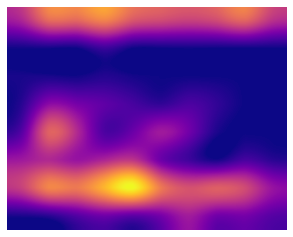

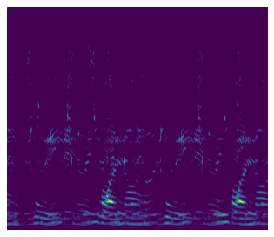

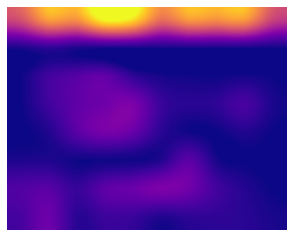

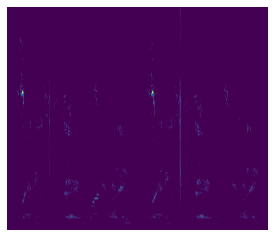

In [18]:
do("speech")

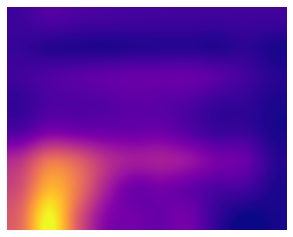

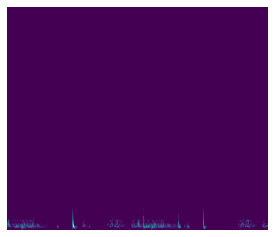

In [45]:
draw("/home/zhengxio/Xingyu/CovidV2/repos/auto/saved_data_all_train/breathing_0_data/feature/merged/id1/ZYSOZDNN_ZYSOZDNN.npy",loaded_model,"")